In [1]:
import os
import tensorflow as tf
from keras import models
from keras import layers
from keras import Sequential
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


KeyboardInterrupt: 

In [ ]:
dataset_name = "crop_dataset_2"
batch_size = 16

In [ ]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Load the dataset

image_size = (380, 380)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 4001 files belonging to 7 classes.
Using 3201 files for training.
Found 4001 files belonging to 7 classes.
Using 800 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['aca_bd', 'aca_md', 'aca_pd', 'nor', 'scc_bd', 'scc_md', 'scc_pd']


In [ ]:
# Obtain the number of samples
num_train_samples = 0
for images, labels in train_ds:
    num_train_samples += images.shape[0]

num_val_samples = 0
for images, labels in val_ds:
    num_val_samples += images.shape[0]




In [ ]:
# Print the dimensions of the training dataset
for images, labels in train_ds:
    print(images.shape)
    print(labels.shape)
    break

(16, 380, 380, 3)
(16,)


In [ ]:
for images, labels in train_ds:
    print(images[0])
    print(labels[0])
    break

tf.Tensor(
[[[185.87535    86.68906   134.0838   ]
  [253.82964   186.9737    212.45361  ]
  [205.88089   168.0547    181.34418  ]
  ...
  [201.7577     83.747185  180.0312   ]
  [206.39468    88.040146  183.5851   ]
  [202.28105    81.145325  176.9327   ]]

 [[189.37189    92.87812   146.49724  ]
  [237.24446   172.47021   203.45152  ]
  [212.58519   175.59003   194.89404  ]
  ...
  [194.268      84.38503   175.5311   ]
  [194.75212    88.82352   174.74109  ]
  [200.53392    96.75838   183.14066  ]]

 [[193.7867     99.40789   164.42383  ]
  [224.69183   158.77078   201.77078  ]
  [211.25693   168.04709   199.17937  ]
  ...
  [204.31642   104.1059    190.07951  ]
  [205.4523    107.10062   193.07913  ]
  [205.9307    113.32067   197.85182  ]]

 ...

 [[201.48425   164.11021   204.0841   ]
  [199.11005   143.97842   193.93564  ]
  [202.6842    122.289474  190.63158  ]
  ...
  [119.472275    7.1852465 167.5244   ]
  [146.89171    16.028015  202.39122  ]
  [162.99103    27.521528  199.43

In [ ]:
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)


Number of training samples: 3201
Number of validation samples: 800


Each EfficientNet variant has a specific input size requirement. Here are the input sizes for some popular EfficientNet models:

EfficientNetB0: (224, 224, 3)
EfficientNetB1: (240, 240, 3)
EfficientNetB2: (260, 260, 3)
EfficientNetB3: (300, 300, 3)
EfficientNetB4: (380, 380, 3)
EfficientNetB5: (456, 456, 3)
EfficientNetB6: (528, 528, 3)
EfficientNetB7: (600, 600, 3)
These sizes represent the input dimensions (height, width, number of channels) that the models expect. Therefore, when using any EfficientNet variant, you need to resize your images to match the corresponding input size before feeding them into the model.

In [ ]:
base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')


# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),    
])



# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers in the base model for fine-tuning

for layer in base_model.layers[-10:]:
    layer.trainable = True

#Capa de entradas. No se si eficientnet ya espera 225x225 o es 224 x 224. En realidad la efficient net ya tiene un parametro de input shape...
# Capa de entradas

entradas = layers.Input((380, 380, 3))

# Apply data augmentation to the input images
x = data_augmentation(entradas)


# Pass the augmented images through the base model
x = base_model(x)




# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(7, activation='softmax')(x)

modelo = Model(inputs = entradas, outputs = salidas)

modelo.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
modelo.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 380, 380, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 18,595,430
Trainable params: 3,236,871
Non-trainable params: 15,358,559
_________________________________________________________________


In [ ]:
num_params = modelo.count_params()
print("Number of parameters:", num_params)

Number of parameters: 18595430


In [ ]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

## Para hacer un training con weights

In [ ]:

# # Calculate class weights
# # class_weights = tf.class_weight.compute_class_weight('balanced', tf.unique(train_ds.labels)[0], train_ds.labels)

# # Convert class weights to dictionary
# # class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# # history = modelo.fit(
# #     train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback], class_weight=class_weights_dict
# # )

In [ ]:
mlflow.end_run()

In [ ]:
# Start an MLflow run
mlflow.start_run()
mlflow.set_experiment('scientific_data')
# Log the name of the dataset
mlflow.log_param("dataset_name", dataset_name)
# Log the number of samples in the dataset
#   mlflow.log_param("num_samples_train", num_train_samples)
#   mlflow.log_param("num_samples_train", num_val_samples)
tf.keras.backend.clear_session()



epochs = 20
history = modelo.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)
 
# Evaluate the model
loss, accuracy = modelo.evaluate(val_ds)

#Logging


mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)

mlflow.log_param("parameters", num_params)

mlflow.log_metric("val_loss", loss)
mlflow.log_metric("val_accuracy", accuracy)




Epoch 1/20
201/201 [==============================] - 183s 724ms/step - loss: 1.2102 - accuracy: 0.5608 - val_loss: 1.1781 - val_accuracy: 0.6137


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
201/201 [==============================] - 138s 683ms/step - loss: 0.9340 - accuracy: 0.6614 - val_loss: 1.1379 - val_accuracy: 0.6525
Epoch 3/20
201/201 [==============================] - 146s 723ms/step - loss: 0.8512 - accuracy: 0.6973 - val_loss: 0.6286 - val_accuracy: 0.7625
Epoch 4/20
201/201 [==============================] - 126s 624ms/step - loss: 0.7691 - accuracy: 0.7266 - val_loss: 0.7270 - val_accuracy: 0.7500
Epoch 5/20
201/201 [==============================] - 129s 640ms/step - loss: 0.7117 - accuracy: 0.7420 - val_loss: 0.5954 - val_accuracy: 0.7713
Epoch 6/20
201/201 [==============================] - 151s 750ms/step - loss: 0.6778 - accuracy: 0.7538 - val_loss: 0.7137 - val_accuracy: 0.7650
Epoch 7/20
201/201 [==============================] - 138s 684ms/step - loss: 0.6257 - accuracy: 0.7716 - val_loss: 0.5871 - val_accuracy: 0.7800
Epoch 8/20
201/201 [==============================] - 140s 693ms/step - loss: 0.5771 - accuracy: 0.7898 - val_loss: 0.5382 -

In [ ]:
#Guardo el modelo en la última epoch. Esto 
modelo.save(folder_date + '/modelo_entrenado.h5')


In [ ]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
folder_date + "/accuracy.png"

'old_models/2023_08_18-09_34_22_AM/accuracy.png'

In [ ]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')

plt.savefig(folder_date + "/loss.png")
plt.show()





dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 5, 3, 3, 2, 3, 2, 2, 2, 2, 3, 4, 4, 4, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 6, 3, 3, 3, 3, 4, 5, 4, 4, 4, 4, 4, 1, 4, 4, 5, 4, 1, 4, 4, 4, 0, 5, 6, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 2, 6, 2, 6, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


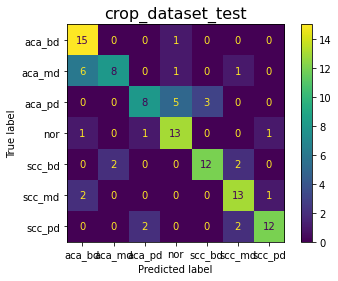

Precision: 0.7402339723768295
Recall: 0.7232142857142857
Accuracy: 0.7232142857142857


In [ ]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []
directory = "crop_dataset_test"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}


for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(380,380))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = modelo.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca_bd' in filename:
        true_labels.append(0)
    elif 'aca_md' in filename:
        true_labels.append(1)
    elif 'aca_pd' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(3)
    elif 'scc_bd' in filename:
        true_labels.append(4)    
    elif 'scc_md' in filename:
        true_labels.append(5)
    elif 'scc_pd' in filename:
        true_labels.append(6)
    
    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()

